# Orthographic Control in Token-Based Language Models via Lightweight Fine-Tuning

Large language models (LLMs) are notoriously bad at spelling. This is partly because tokenizers break words into smaller pieces, so the model learns about sub-word units rather than whole words and their spellings.

In this work, we use supervised fine-tuning (SFT) and a technique called Parameter-Efficient Fine-Tuning (PEFT) with Low-Rank Adaptation (LoRA) to teach a small LLM how to spell words.

## What this notebook include

  **Setup**: Import libraries and configure the environment.

  **Load the tokenizer and base model**: Use a small, instruction-tuned model as our starting point.

  **Import the dataset**: The dataset is constructed from the 25,000 most frequent English words provided by the wordfreq library. Words
are lowercased and filtered to include only alphabetic tokens,
excluding numerals, punctuation, and compound forms

  **Evaluate the model under zero-shot scenario**: Test the model's spelling ability *before* fine-tuning to establish a baseline.

  **Evaluate the model under few-shot scenario**: Test the model's spelling ability *before* fine-tuning along with providing few-shot prompt examples.
  
  **Configure LoRA and train**: Attach a LoRA adapter to the model and fine-tune it on the spelling dataset.

  **Evaluate the fine-tuned model**: Test the model again to see if its spelling has improved.

  **Plot Results on the fine tuned model**:


## Setup

In [1]:
# Setup imports
!pip -q install Levenshtein
!pip -q install trl
!pip -q install peft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import re
import json
import string
import csv
from collections import defaultdict
from datasets import Dataset

import Levenshtein

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig

# Use GPU, MPS, or CPU, in that order of preference
if torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")
torch.set_num_threads(max(1, os.cpu_count() // 2))
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.9/530.9 kB 32.8 MB/s eta 0:00:00
Using device: cuda


## Load the tokenizer and base model

The model `HuggingFaceTB/SmolLM2-135M-Instruct` is a small, instruction-tuned model that's suitable for this exercise. It has 135 million parameters, making it lightweight and efficient for fine-tuning.

In [2]:
# https://huggingface.co/docs/transformers/en/models
# https://huggingface.co/docs/transformers/en/fast_tokenizers

# Model ID for SmolLM2-135M-Instruct
model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
)

# Copy the model to the device (GPU, MPS, or CPU)
model = model.to(device)

print("Model parameters (total):", sum(p.numel() for p in model.parameters()))

## Import the dataset

In [41]:
# Create a list of words of different lengths
# fmt: off
def read_words(words_file: str, min_len: int, max_len: int):
    """
    Reads a text file with one word per line. Filters to alphabetic words.
    """
    if not words_file or not os.path.exists(words_file):
        # Fallback small list (use your own file for serious experiments)
        fallback = [
            "danger", "deactivation", "decomposition", "deduction", "definition",
            "deforestation", "design", "development", "dimensional", "directive",
            "discover", "disruptive", "earthquake", "ecosystem", "elaboration",
            "empathy", "energy", "environment", "evolution", "expedition",
            "explosion", "exponential", "expression", "fauna", "flora",
            "flourish", "foliage", "forage", "forest", "gather",
            "grizzly", "growth", "guardian", "habitat", "hazard",
            "hibernate", "humidity", "hydration", "incubate"
        ]
        words = fallback
    else:
        with open(words_file, "r", encoding="utf-8") as f:
            raw = [line.strip() for line in f.readlines()]
        words = []
        for w in raw:
            w = w.strip()
            if not w:
                continue
            # keep simple alphabetic tokens (paper-friendly controlled setting)
            if re.fullmatch(r"[A-Za-z]+", w):
                words.append(w)

    # filter by length
    words = [w for w in words if min_len <= len(w) <= max_len]
    # deduplicate while keeping order
    seen = set()
    deduped = []
    for w in words:
        lw = w.lower()
        if lw not in seen:
            seen.add(lw)
            deduped.append(lw)
    return deduped

# Few-shot prompting
Create a Hugging Face Dataset with the prompt that asks the model to spell the word with hyphens between the letters.

In [44]:
# Create a Hugging Face Dataset with the prompt that asks the model to spell the word
# with hyphens between the letters.

def generate_records_fewshot():
    ALL_WORDS = read_words("words_25k.txt" ,4,14)
    for word in ALL_WORDS:
        yield {
            # We will use the SFTTrainer which expects a certain format for prompt and completions pair
            # in order for it to automatically construct the right tokenizations to train the model.
            # See the documentation for more details:
            # https://huggingface.co/docs/trl/en/sft_trainer#expected-dataset-type-and-format
            "prompt": (
                f"You spell words with hyphens between the letters like this W-O-R-D.\nWord:\n{word}\n\n"
                + "Spelling:\n"
            ),
            "completion": "-".join(word).upper() + ".",  # Of the form W-O-R-D.
        }

ds_fewshot = Dataset.from_generator(generate_records_fewshot)

# Show the first item
ds_fewshot[0]

Generating train split: 0 examples [00:00, ? examples/s]

{'prompt': 'You spell words with hyphens between the letters like this W-O-R-D.\nWord:\nthat\n\nSpelling:\n',
 'completion': 'T-H-A-T.'}

# Zero shot prompting
Create a Hugging Face Dataset with the prompt that asks the model to spell the word with hyphens between the letters.

In [45]:
# Create a Hugging Face Dataset with the prompt that asks the model to spell the word
# with hyphens between the letters.

def generate_records_zeroshot():
    ALL_WORDS = read_words("words_25k.txt" ,4,14)
    for word in ALL_WORDS:
        yield {
            # We will use the SFTTrainer which expects a certain format for prompt and completions pair
            # in order for it to automatically construct the right tokenizations to train the model.
            # See the documentation for more details:
            # https://huggingface.co/docs/trl/en/sft_trainer#expected-dataset-type-and-format
            "prompt": (
                f"You spell words with hyphens between the letters \n\n"
                + "Spelling:\n"
            ),
            "completion": "-".join(word).upper() + ".",  # Of the form W-O-R-D.
        }

ds_zeroshot = Dataset.from_generator(generate_records_zeroshot)

# Show the first item
ds_zeroshot[0]

{'prompt': 'You spell words with hyphens between the letters \n\nSpelling:\n',
 'completion': 'T-H-A-T.'}

In [46]:
# Student Task: Split the dataset into training and testing sets
# See: train_test_split
ds_fewshot = ds_fewshot.train_test_split(test_size=0.25, seed=42)
ds_zeroshot = ds_zeroshot.train_test_split(test_size=0.25, seed=42)

In [6]:
# View the training set
# No changes needed in this cell

ds_fewshot["train"]
ds_zeroshot["train"]

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 16941
})

## Evaluate the base model - Zero and Few shot

Before we fine-tune the model, let's see how it performs on the spelling task. We'll create a helper function to generate a spelling for a given word and compare it to the correct answer.

In [47]:


def character_error_rate(pred: str, target: str) -> float:
    """
    Compute Character Error Rate (CER) using Levenshtein distance.
    """
    if len(target) == 0:
        return 0.0 if len(pred) == 0 else 1.0

    return Levenshtein.distance(pred, target) / len(target)


In [48]:
# A function to check the model's spelling.
# This function will take a model, tokenizer, prompt, and the correct spelling.
# It should generate text from the model and compare the model's proposed spelling
# to the actual spelling.
# Retruning:
# (1)The proportion of characters that were correct.
# (2)Exact Match Score (0 or 1)
# (3) CER ,i.e. Character Error Rate

# ---------------------------
# 1) Load frequency bands CSV
# ---------------------------
def load_band_map(path="words_25k_with_bands.csv"):
    """
    Returns:
      band_map: dict word -> band (high/medium/low)
      rank_map: dict word -> frequency_rank (int)
    """
    band_map = {}
    rank_map = {}
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            w = row["word"].strip().lower()
            band_map[w] = row["band"].strip().lower()
            rank_map[w] = int(row["frequency_rank"])
    return band_map, rank_map

band_map, rank_map = load_band_map("words_25k_with_bands.csv")


# ---------------------------
# 2) Helpers: normalize + length bucket
# ---------------------------
def normalize_word(s: str) -> str:
    if not s:
        return ""
    s = s.lower()
    s = s.replace("\u00a0", " ")      # non-breaking space
    s = re.sub(r"\s+", "", s)         # remove ALL whitespace
    s = s.strip(string.punctuation)   # remove punctuation at ends
    return s

def length_bucket(L: int) -> str:
    # Change buckets to match your paper/figure bins
    if L <= 3: return "1-3"
    if L <= 5: return "4-5"
    if L <= 7: return "6-7"
    if L <= 9: return "8-9"
    return "10+"


# ---------------------------
# 3) Your spelling checker
# ---------------------------
def check_spelling(model, tokenizer, prompt: str, actual_spelling: str, max_new_tokens: int = 30):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    gen = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        use_cache=True,
    )

    output = tokenizer.decode(gen[0], skip_special_tokens=True)

    # Extract model's proposed spelling
    proposed_spelling = output.split("Spelling:")[-1].strip().split("\n")[0].strip()
    proposed_spelling = proposed_spelling.lower()

    # Clean actual spelling
    actual_spelling = actual_spelling.strip().strip(".").lower()

    # Remove hyphens (if your format includes them)
    proposed_spelling = proposed_spelling.replace("-", "")
    actual_spelling = actual_spelling.replace("-", "")

    proposed_spelling = normalize_word(proposed_spelling)
    actual_spelling = normalize_word(actual_spelling)

    if not proposed_spelling or not actual_spelling:
        # If empty output, treat as all-wrong: PWCA=0, EM=0, CER=1 (max error)
        return 0.0, 0, 1.0, proposed_spelling, actual_spelling

    # (1) PWCA: position-wise character accuracy (zip ignores extra tail chars)
    num_correct = sum(1 for a, b in zip(actual_spelling, proposed_spelling) if a == b)
    prop_correct = num_correct / len(actual_spelling)

    # (2) Exact Match (EM)
    exact = int(proposed_spelling == actual_spelling)

    # (3) CER (you already have character_error_rate defined somewhere)
    cer = character_error_rate(proposed_spelling, actual_spelling)

    return prop_correct, exact, cer, proposed_spelling, actual_spelling


i=0
for i in range (3):
    check_spelling(
        model=model,
        tokenizer=tokenizer,
        prompt=ds_zeroshot["test"][i]["prompt"],
        actual_spelling=ds_zeroshot["test"][i]["completion"],
    )

# Evaluate Base model under Zero shot scenario


In [50]:
# Evaluate the base model's spelling ability - Zeroshot
# We expect it to perform poorly, as it hasn't been trained for this task.
# ---------------------------
# Aggregation utilities
# ---------------------------
def update_aggs(aggs, pwca, exact, cer):
    aggs["n"] += 1
    aggs["sum_pwca"] += pwca
    aggs["sum_exact"] += exact
    aggs["sum_cer"] += cer

def finalize_aggs(aggs):
    n = aggs["n"]
    if n == 0:
        return {"n": 0, "pwca": None, "exact_acc": None, "cer": None}
    return {
        "n": n,
        "pwca": aggs["sum_pwca"] / n,
        "exact_acc": aggs["sum_exact"] / n,
        "cer": aggs["sum_cer"] / n,
    }

def print_summary(title, stats):
    print(f"\n=== {title} ===")
    if stats["n"] == 0:
        print("No samples.")
        return
    print(f"n={stats['n']}")
    print(f"PWCA:      {stats['pwca']:.4f}")
    print(f"Exact Acc: {stats['exact_acc']:.4f}")
    print(f"CER:       {stats['cer']:.4f}")


# ---------------------------
# Main loop: compute overall + per band + per length
# ---------------------------
overall = defaultdict(float)
overall["n"] = 0

by_band = defaultdict(lambda: defaultdict(float))
by_length = defaultdict(lambda: defaultdict(float))       # exact length: 3,4,5,...
by_len_bucket = defaultdict(lambda: defaultdict(float))   # bucket: "1-3","4-5",...

# OPTIONAL: store per-word rows for plotting later
rows_for_plot = []

N = 1500 # len(ds_zeroshot["test"])  # change as needed
for example in ds_zeroshot["test"].select(range(N)):
    prompt = example["prompt"]
    completion = example["completion"]

    # Normalize the target word so it matches the CSV key format
    target_word = normalize_word(completion.replace("-", "").replace(".", ""))
    L = len(target_word)

    band = band_map.get(target_word, "unknown")  # "unknown" if not in top-25k filtered list
    lb = length_bucket(L)

    pwca, exact, cer, pred, gold = check_spelling(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        actual_spelling=completion,
        max_new_tokens=20,
    )

    # Update aggregations
    update_aggs(overall, pwca, exact, cer)
    update_aggs(by_band[band], pwca, exact, cer)
    update_aggs(by_length[L], pwca, exact, cer)
    update_aggs(by_len_bucket[lb], pwca, exact, cer)

    rows_for_plot.append({
        "word": target_word,
        "length": L,
        "length_bucket": lb,
        "band": band,
        "pwca": pwca,
        "exact": exact,
        "cer": cer,
        "pred": pred,
        "gold": gold
    })

# ---------------------------
# Print results
# ---------------------------
print_summary("OVERALL", finalize_aggs(overall))

for band in ["high", "medium", "low", "unknown"]:
    print_summary(f"BY BAND: {band}", finalize_aggs(by_band[band]))

# Per length (exact) — can be long; you can comment this out if noisy
for L in sorted(by_length.keys()):
    print_summary(f"BY LENGTH: {L}", finalize_aggs(by_length[L]))

# Per length bucket (clean for Figure 1 / Figure 2)
for lb in ["1-3", "4-5", "6-7", "8-9", "10+"]:
    print_summary(f"BY LENGTH BUCKET: {lb}", finalize_aggs(by_len_bucket[lb]))


# ---------------------------
# Save per-word results for plotting Figure 1 later
# ---------------------------
out_csv = "eval_results_with_band_and_length.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(rows_for_plot[0].keys()))
    w.writeheader()
    w.writerows(rows_for_plot)

print(f"\nWrote per-word results to: {out_csv}")




=== OVERALL ===
n=1500
PWCA:      0.0599
Exact Acc: 0.0000
CER:       0.9748

=== BY BAND: high ===
n=302.0
PWCA:      0.0601
Exact Acc: 0.0000
CER:       1.0350

=== BY BAND: medium ===
n=609.0
PWCA:      0.0635
Exact Acc: 0.0000
CER:       0.9536

=== BY BAND: low ===
n=589.0
PWCA:      0.0561
Exact Acc: 0.0000
CER:       0.9658

=== BY BAND: unknown ===
No samples.

=== BY LENGTH: 4 ===
n=146.0
PWCA:      0.0582
Exact Acc: 0.0000
CER:       1.4983

=== BY LENGTH: 5 ===
n=217.0
PWCA:      0.0645
Exact Acc: 0.0000
CER:       1.1760

=== BY LENGTH: 6 ===
n=246.0
PWCA:      0.0576
Exact Acc: 0.0000
CER:       1.0020

=== BY LENGTH: 7 ===
n=259.0
PWCA:      0.0789
Exact Acc: 0.0000
CER:       0.8847

=== BY LENGTH: 8 ===
n=194.0
PWCA:      0.0432
Exact Acc: 0.0000
CER:       0.8486

=== BY LENGTH: 9 ===
n=181.0
PWCA:      0.0626
Exact Acc: 0.0000
CER:       0.8066

=== BY LENGTH: 10 ===
n=117.0
PWCA:      0.0564
Exact Acc: 0.0000
CER:       0.7872

=== BY LENGTH: 11 ===
n=67.0
PWCA:    

# Evaluate Base model under Few shot scenario


In [ ]:
# Evaluate the base model's spelling ability - FEWSHOT
# We expect it to perform poorly, as it hasn't been trained for this task.
# ---------------------------
# Aggregation utilities
# ---------------------------
def update_aggs(aggs, pwca, exact, cer):
    aggs["n"] += 1
    aggs["sum_pwca"] += pwca
    aggs["sum_exact"] += exact
    aggs["sum_cer"] += cer

def finalize_aggs(aggs):
    n = aggs["n"]
    if n == 0:
        return {"n": 0, "pwca": None, "exact_acc": None, "cer": None}
    return {
        "n": n,
        "pwca": aggs["sum_pwca"] / n,
        "exact_acc": aggs["sum_exact"] / n,
        "cer": aggs["sum_cer"] / n,
    }

def print_summary(title, stats):
    print(f"\n=== {title} ===")
    if stats["n"] == 0:
        print("No samples.")
        return
    print(f"n={stats['n']}")
    print(f"PWCA:      {stats['pwca']:.4f}")
    print(f"Exact Acc: {stats['exact_acc']:.4f}")
    print(f"CER:       {stats['cer']:.4f}")


# ---------------------------
# Main loop: compute overall + per band + per length
# ---------------------------
overall = defaultdict(float)
overall["n"] = 0

by_band = defaultdict(lambda: defaultdict(float))
by_length = defaultdict(lambda: defaultdict(float))       # exact length: 3,4,5,...
by_len_bucket = defaultdict(lambda: defaultdict(float))   # bucket: "1-3","4-5",...

# OPTIONAL: store per-word rows for plotting later
rows_for_plot = []

N = 1500 # len(ds_fewshot["test"])  # change as needed
for example in ds_fewshot["test"].select(range(N)):
    prompt = example["prompt"]
    completion = example["completion"]

    # Normalize the target word so it matches the CSV key format
    target_word = normalize_word(completion.replace("-", "").replace(".", ""))
    L = len(target_word)

    band = band_map.get(target_word, "unknown")  # "unknown" if not in top-25k filtered list
    lb = length_bucket(L)

    pwca, exact, cer, pred, gold = check_spelling(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        actual_spelling=completion,
        max_new_tokens=20,
    )

    # Update aggregations
    update_aggs(overall, pwca, exact, cer)
    update_aggs(by_band[band], pwca, exact, cer)
    update_aggs(by_length[L], pwca, exact, cer)
    update_aggs(by_len_bucket[lb], pwca, exact, cer)

    rows_for_plot.append({
        "word": target_word,
        "length": L,
        "length_bucket": lb,
        "band": band,
        "pwca": pwca,
        "exact": exact,
        "cer": cer,
        "pred": pred,
        "gold": gold
    })

# ---------------------------
# Print results
# ---------------------------
print_summary("OVERALL", finalize_aggs(overall))

for band in ["high", "medium", "low", "unknown"]:
    print_summary(f"BY BAND: {band}", finalize_aggs(by_band[band]))

# Per length (exact) — can be long; you can comment this out if noisy
for L in sorted(by_length.keys()):
    print_summary(f"BY LENGTH: {L}", finalize_aggs(by_length[L]))

# Per length bucket (clean for Figure 1 / Figure 2)
for lb in ["1-3", "4-5", "6-7", "8-9", "10+"]:
    print_summary(f"BY LENGTH BUCKET: {lb}", finalize_aggs(by_len_bucket[lb]))


# ---------------------------
# Save per-word results for plotting Figure 1 later
# ---------------------------
out_csv = "eval_results_with_band_and_length.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(rows_for_plot[0].keys()))
    w.writeheader()
    w.writerows(rows_for_plot)

print(f"\nWrote per-word results to: {out_csv}")




=== OVERALL ===
n=5647
PWCA:      0.7257
Exact Acc: 0.5782
CER:       0.2775

=== BY BAND: high ===
n=1097.0
PWCA:      0.5138
Exact Acc: 0.4676
CER:       0.5008

=== BY BAND: medium ===
n=2269.0
PWCA:      0.7794
Exact Acc: 0.6439
CER:       0.2208

=== BY BAND: low ===
n=2281.0
PWCA:      0.7742
Exact Acc: 0.5660
CER:       0.2266

=== BY BAND: unknown ===
No samples.

=== BY LENGTH: 4 ===
n=511.0
PWCA:      0.6683
Exact Acc: 0.6360
CER:       0.3694

=== BY LENGTH: 5 ===
n=796.0
PWCA:      0.7337
Exact Acc: 0.6608
CER:       0.2686

=== BY LENGTH: 6 ===
n=907.0
PWCA:      0.7339
Exact Acc: 0.6141
CER:       0.2648

=== BY LENGTH: 7 ===
n=994.0
PWCA:      0.7427
Exact Acc: 0.5765
CER:       0.2565

=== BY LENGTH: 8 ===
n=811.0
PWCA:      0.7119
Exact Acc: 0.5364
CER:       0.2865

=== BY LENGTH: 9 ===
n=653.0
PWCA:      0.7483
Exact Acc: 0.5544
CER:       0.2532

=== BY LENGTH: 10 ===
n=463.0
PWCA:      0.6981
Exact Acc: 0.4665
CER:       0.3002

=== BY LENGTH: 11 ===
n=257.0
PWCA:

As expected, the base model is terrible at spelling. It mostly just repeats the word back. Now, let's fine-tune it.

## Configure LoRA and train the model

Let’s attach a LoRA adapter to the base model. We use a LoRA config so only a tiny fraction of parameters are trainable. Read more here: [LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

In [9]:
# Configure LoRA for a causal LM and wrap the model with get_peft_model
# Complete the sections with **********

# Print how many params are trainable at first
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(
    f"Trainable params BEFORE: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)"
)

# https://huggingface.co/docs/peft/package_reference/lora
lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

# Print the number of trainable parameters after applying LoRA
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(
    f"Trainable params AFTER: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)"
)

Trainable params BEFORE: 134,515,008 / 134,515,008 (100.00%)
Trainable params AFTER: 3,686,400 / 138,201,408 (2.67%)


In here, we use `SFTConfig` from the TRL library, which is a wrapper around the standard `TrainingArguments`.

In [10]:
# SFTConfig for a quick training run
output_dir = "data/model"
# https://huggingface.co/docs/trl/en/sft_trainer#trl.SFTConfig


training_args = SFTConfig(
    output_dir="data/model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=5e-4,
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    report_to=[],
    fp16=True,          # ✅ turn ON
    bf16=False,         # (Colab T4 does not support bf16)
    use_cpu=False,      # ❗ MUST be False
    lr_scheduler_type="cosine",
)



Now we define the `SFTTrainer` and run the fine-tuning process.

In [11]:
# Create and run the SFTTrainer
#https://huggingface.co/docs/trl/en/sft_trainer

trainer = SFTTrainer(
    model=model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    args=training_args,
)
trainer.train()
trainer.save_model("data/model")
tokenizer.save_pretrained("data/model")


## Evaluate the fine-tuned model

In [12]:
# Evaluate the fine tuned model's spelling ability
# We expect it to perform poorly, as it hasn't been trained for this task.
# ---------------------------
# Aggregation utilities
# ---------------------------
def update_aggs(aggs, pwca, exact, cer):
    aggs["n"] += 1
    aggs["sum_pwca"] += pwca
    aggs["sum_exact"] += exact
    aggs["sum_cer"] += cer

def finalize_aggs(aggs):
    n = aggs["n"]
    if n == 0:
        return {"n": 0, "pwca": None, "exact_acc": None, "cer": None}
    return {
        "n": n,
        "pwca": aggs["sum_pwca"] / n,
        "exact_acc": aggs["sum_exact"] / n,
        "cer": aggs["sum_cer"] / n,
    }

def print_summary(title, stats):
    print(f"\n=== {title} ===")
    if stats["n"] == 0:
        print("No samples.")
        return
    print(f"n={stats['n']}")
    print(f"PWCA:      {stats['pwca']:.4f}")
    print(f"Exact Acc: {stats['exact_acc']:.4f}")
    print(f"CER:       {stats['cer']:.4f}")


# ---------------------------
# Main loop: compute overall + per band + per length
# ---------------------------
overall = defaultdict(float)
overall["n"] = 0

by_band = defaultdict(lambda: defaultdict(float))
by_length = defaultdict(lambda: defaultdict(float))       # exact length: 3,4,5,...
by_len_bucket = defaultdict(lambda: defaultdict(float))   # bucket: "1-3","4-5",...

# OPTIONAL: store per-word rows for plotting later
rows_for_plot = []

N = 1500  # change as needed
for example in ds["test"].select(range(N)):
    prompt = example["prompt"]
    completion = example["completion"]

    # Normalize the target word so it matches the CSV key format
    target_word = normalize_word(completion.replace("-", "").replace(".", ""))
    L = len(target_word)

    band = band_map.get(target_word, "unknown")  # "unknown" if not in top-25k filtered list
    lb = length_bucket(L)

    pwca, exact, cer, pred, gold = check_spelling(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        actual_spelling=completion,
        max_new_tokens=20,
    )

    # Update aggregations
    update_aggs(overall, pwca, exact, cer)
    update_aggs(by_band[band], pwca, exact, cer)
    update_aggs(by_length[L], pwca, exact, cer)
    update_aggs(by_len_bucket[lb], pwca, exact, cer)

    rows_for_plot.append({
        "word": target_word,
        "length": L,
        "length_bucket": lb,
        "band": band,
        "pwca": pwca,
        "exact": exact,
        "cer": cer,
        "pred": pred,
        "gold": gold
    })

# ---------------------------
# Print results
# ---------------------------
print_summary("OVERALL", finalize_aggs(overall))

for band in ["high", "medium", "low", "unknown"]:
    print_summary(f"BY BAND: {band}", finalize_aggs(by_band[band]))

# Per length (exact) — can be long; you can comment this out if noisy
for L in sorted(by_length.keys()):
    print_summary(f"BY LENGTH: {L}", finalize_aggs(by_length[L]))

# Per length bucket (clean for Figure 1 / Figure 2)
for lb in ["1-3", "4-5", "6-7", "8-9", "10+"]:
    print_summary(f"BY LENGTH BUCKET: {lb}", finalize_aggs(by_len_bucket[lb]))


# ---------------------------
# Save per-word results for plotting Figure 1 later
# ---------------------------
out_csv = "eval_results_with_band_and_length.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(rows_for_plot[0].keys()))
    w.writeheader()
    w.writerows(rows_for_plot)

print(f"\nWrote per-word results to: {out_csv}")




=== OVERALL ===
n=1500
PWCA:      0.7769
Exact Acc: 0.5347
CER:       0.1813

=== BY BAND: high ===
n=302.0
PWCA:      0.6686
Exact Acc: 0.3808
CER:       0.2924

=== BY BAND: medium ===
n=609.0
PWCA:      0.7936
Exact Acc: 0.5583
CER:       0.1582

=== BY BAND: low ===
n=589.0
PWCA:      0.8152
Exact Acc: 0.5891
CER:       0.1483

=== BY BAND: unknown ===
No samples.

=== BY LENGTH: 4 ===
n=146.0
PWCA:      0.9144
Exact Acc: 0.8151
CER:       0.0839

=== BY LENGTH: 5 ===
n=217.0
PWCA:      0.8479
Exact Acc: 0.7005
CER:       0.1364

=== BY LENGTH: 6 ===
n=246.0
PWCA:      0.8394
Exact Acc: 0.6911
CER:       0.1396

=== BY LENGTH: 7 ===
n=259.0
PWCA:      0.8367
Exact Acc: 0.6371
CER:       0.1445

=== BY LENGTH: 8 ===
n=194.0
PWCA:      0.7146
Exact Acc: 0.4691
CER:       0.2210

=== BY LENGTH: 9 ===
n=181.0
PWCA:      0.6955
Exact Acc: 0.3591
CER:       0.2400

=== BY LENGTH: 10 ===
n=117.0
PWCA:      0.6718
Exact Acc: 0.3419
CER:       0.2470

=== BY LENGTH: 11 ===
n=67.0
PWCA:    

##  Results Visualization
Figure: Spelling error rate as a function of word length across frequency bands.Low-frequency words exhibit a steeper degradation curve, indicating reduced robustness to orthographic complexity.


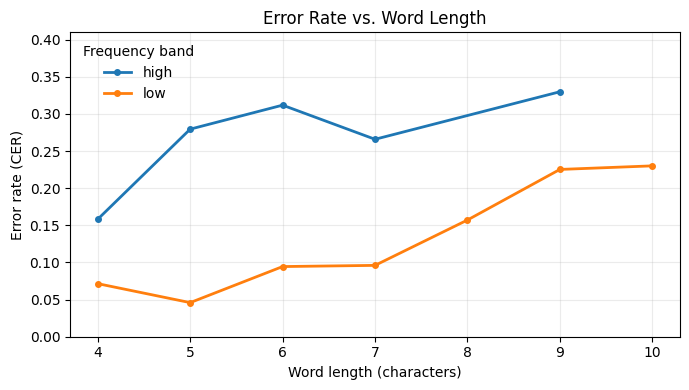

In [40]:
# Figure
# Spelling error rate as a function of word length across frequency bands.
# Low-frequency words exhibit a steeper degradation curve, indicating reduced
# robustness to orthographic complexity.

import pandas as pd
import matplotlib.pyplot as plt
# -------------------------
# Config
# -------------------------
RESULTS_CSV = "eval_results_with_band_and_length.csv"
BANDS = ["high", "low"]          # ← medium removed
MIN_N_PER_POINT = 30             # filter noisy tail

# -------------------------
# Load + clean
# -------------------------
df = pd.read_csv(RESULTS_CSV)
df["band"] = df["band"].astype(str).str.strip().str.lower()
df = df[df["band"].isin(BANDS)].copy()

# -------------------------
# Aggregate mean CER + counts
# -------------------------
g = df.groupby(["length", "band"])["cer"]
summary = g.mean().reset_index(name="cer")
counts  = g.size().reset_index(name="n")

plot_df = summary.merge(counts, on=["length", "band"])
plot_df = plot_df[plot_df["n"] >= MIN_N_PER_POINT]
plot_df = plot_df.sort_values(["band", "length"])

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7, 4))

for band in BANDS:
    sub = plot_df[plot_df["band"] == band]
    if sub.empty:
        continue
    plt.plot(
        sub["length"],
        sub["cer"],
        marker="o",
        linewidth=2,
        markersize=4,
        label=band
    )

plt.xlabel("Word length (characters)")
plt.ylabel("Error rate (CER)")
plt.title("Error Rate vs. Word Length")
plt.grid(alpha=0.25)
plt.legend(title="Frequency band", frameon=False)

# Tight y-limits for readability
ymax = plot_df["cer"].max()
plt.ylim(0, min(1.0, ymax + 0.08))

plt.tight_layout()
plt.show()

# Optional save
# plt.savefig("fig2_error_vs_length_high_vs_low.png", dpi=300, bbox_inches="tight")




##  Results Visualization
Figure: Spelling accuracy stratified by word length and lexical frequency band.Performance degrades with increasing orthographic complexity and decreasing lexical familiarity, revealing systematic error patterns not observable in aggregate metrics.

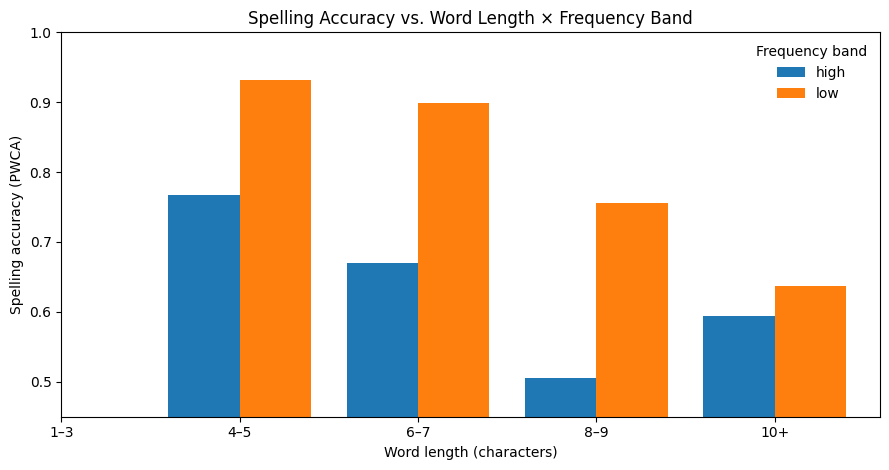

In [37]:
#Figure
# Spelling accuracy stratified by word length and lexical frequency band.
# Performance degrades with increasing orthographic complexity and decreasing
# lexical familiarity, revealing systematic error patterns not observable
# in aggregate metrics.

# Choose what "accuracy" means for this figure:
#  - "exact": exact match accuracy (recommended for "Spelling Accuracy")
#  - "pwca":  position-wise character accuracy (your PWCA)
#  - "1-cer": converts CER into accuracy-like (1 - CER)
# -------------------------
# Config
# -------------------------

# FIG  - PWCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RESULTS_CSV = "eval_results_with_band_and_length.csv"
BANDS = ["high", "low"]     # or ["high","mid", "low"] if you want to add medium
METRIC = "pwca"                       # "pwca" or "1-cer" or "exact"

# ---- load + clean ----
df = pd.read_csv(RESULTS_CSV)
df["band"] = df["band"].astype(str).str.strip().str.lower()
df = df[df["band"].isin(BANDS)].copy()

# ---- length bins (match your existing bins) ----
def length_bin(L):
    if L <= 3: return "1–3"
    if L <= 5: return "4–5"
    if L <= 7: return "6–7"
    if L <= 9: return "8–9"
    return "10+"

df["len_bin"] = df["length"].apply(length_bin)

# ---- choose y metric ----
if METRIC == "pwca":
    df["y"] = df["pwca"].astype(float)
    y_label = "Spelling accuracy (PWCA)"
elif METRIC == "1-cer":
    df["y"] = 1.0 - df["cer"].astype(float)
    y_label = "Spelling accuracy (1 − CER)"
else:
    raise ValueError("METRIC must be 'pwca' or '1-cer'")

# ---- aggregate ----
summary = (
    df.groupby(["len_bin", "band"])["y"]
      .mean()
      .reset_index()
)

# Ensure consistent ordering (including empty bins)
bins = ["1–3", "4–5", "6–7", "8–9", "10+"]
grid = pd.MultiIndex.from_product([bins, BANDS], names=["len_bin", "band"])
summary = summary.set_index(["len_bin", "band"]).reindex(grid).reset_index()

# ---- plot (grouped bars) ----
x = np.arange(len(bins))
width = 0.8 / len(BANDS)

plt.figure(figsize=(9, 4.8))
for i, band in enumerate(BANDS):
    vals = (summary[summary["band"] == band]
            .set_index("len_bin")["y"]
            .reindex(bins))
    plt.bar(x - 0.4 + width/2 + i*width, vals.values, width, label=band)

plt.xticks(x, bins)
plt.xlabel("Word length (characters)")
plt.ylabel(y_label)
plt.title("Spelling Accuracy vs. Word Length × Frequency Band")

plt.ylim(0.45, 1.0)

plt.legend(title="Frequency band", frameon=False)
plt.tight_layout()
plt.show()

# Optional save:
# plt.savefig("fig1_length_x_band_pwca.png", dpi=300, bbox_inches="tight")


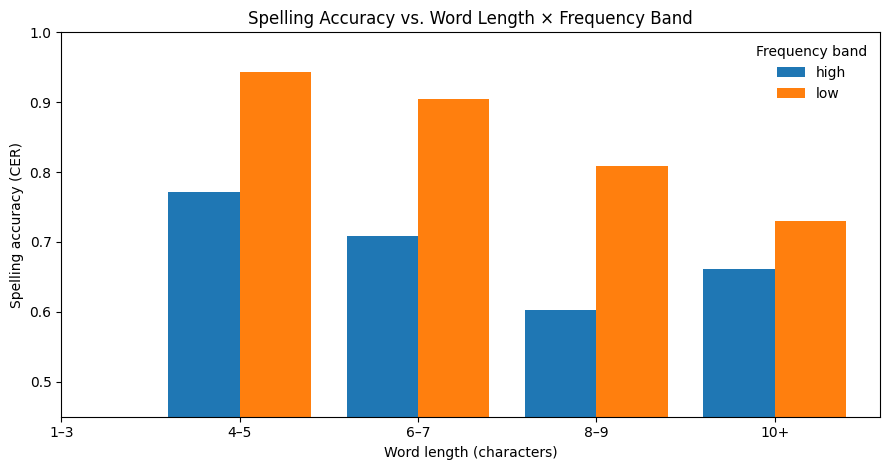

In [39]:
#Figure 1
# Spelling accuracy stratified by word length and lexical frequency band.
# Performance degrades with increasing orthographic complexity and decreasing
# lexical familiarity, revealing systematic error patterns not observable
# in aggregate metrics.

# Choose what "accuracy" means for this figure:
#  - "exact": exact match accuracy (recommended for "Spelling Accuracy")
#  - "pwca":  position-wise character accuracy (your PWCA)
#  - "1-cer": converts CER into accuracy-like (1 - CER)
# -------------------------
# Config
# -------------------------

# FIG  - CER
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RESULTS_CSV = "eval_results_with_band_and_length.csv"
BANDS = ["high", "low"]     # or ["high","mid", "low"] if you want to add medium
METRIC = "1-cer"                       # "pwca" or "1-cer" or "exact"

# ---- load + clean ----
df = pd.read_csv(RESULTS_CSV)
df["band"] = df["band"].astype(str).str.strip().str.lower()
df = df[df["band"].isin(BANDS)].copy()

# ---- length bins (match your existing bins) ----
def length_bin(L):
    if L <= 3: return "1–3"
    if L <= 5: return "4–5"
    if L <= 7: return "6–7"
    if L <= 9: return "8–9"
    return "10+"

df["len_bin"] = df["length"].apply(length_bin)

# ---- choose y metric ----
if METRIC == "pwca":
    df["y"] = df["pwca"].astype(float)
    y_label = "Spelling accuracy (PWCA)"
elif METRIC == "1-cer":
    df["y"] = 1.0 - df["cer"].astype(float)
    y_label = "Spelling accuracy (CER)"
else:
    raise ValueError("METRIC must be 'pwca' or '1-cer'")

# ---- aggregate ----
summary = (
    df.groupby(["len_bin", "band"])["y"]
      .mean()
      .reset_index()
)

# Ensure consistent ordering (including empty bins)
bins = ["1–3", "4–5", "6–7", "8–9", "10+"]
grid = pd.MultiIndex.from_product([bins, BANDS], names=["len_bin", "band"])
summary = summary.set_index(["len_bin", "band"]).reindex(grid).reset_index()

# ---- plot (grouped bars) ----
x = np.arange(len(bins))
width = 0.8 / len(BANDS)

plt.figure(figsize=(9, 4.8))
for i, band in enumerate(BANDS):
    vals = (summary[summary["band"] == band]
            .set_index("len_bin")["y"]
            .reindex(bins))
    plt.bar(x - 0.4 + width/2 + i*width, vals.values, width, label=band)

plt.xticks(x, bins)
plt.xlabel("Word length (characters)")
plt.ylabel(y_label)
plt.title("Spelling Accuracy vs. Word Length × Frequency Band")

plt.ylim(0.45, 1.0)

plt.legend(title="Frequency band", frameon=False)
plt.tight_layout()
plt.show()

# Optional save:
# plt.savefig("fig1_length_x_band_pwca.png", dpi=300, bbox_inches="tight")

# Results Visualization


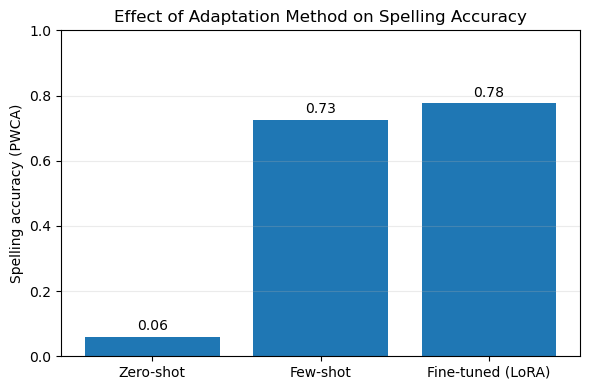

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data (no n column)
df = pd.read_csv("method_overall.csv")

# Order and labels
order  = ["zero_shot", "few_shot", "lora"]
labels = ["Zero-shot", "Few-shot", "Fine-tuned (LoRA)"]

df["method"] = pd.Categorical(df["method"], categories=order, ordered=True)
df = df.sort_values("method")

# Plot

plt.figure(figsize=(6, 4))
plt.bar(labels, df["pwca"].values)

plt.ylabel("Spelling accuracy (PWCA)")
plt.title("Effect of Adaptation Method on Spelling Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.25)
for i, v in enumerate(df["pwca"].values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

# Optional save
# plt.savefig("fig3_method_comparison_pwca.png", dpi=300, bbox_inches="tight")
# plt.savefig("fig3_method_comparison_pwca.pdf", bbox_inches="tight")


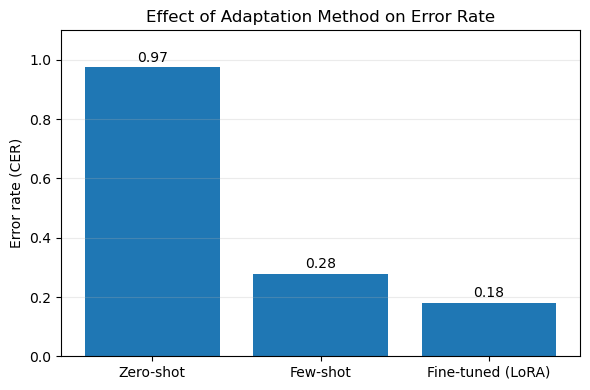

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("method_overall.csv")

order  = ["zero_shot", "few_shot", "lora"]
labels = ["Zero-shot", "Few-shot", "Fine-tuned (LoRA)"]

df["method"] = pd.Categorical(df["method"], categories=order, ordered=True)
df = df.sort_values("method")

plt.figure(figsize=(6, 4))
plt.bar(labels, df["cer"].values)
plt.ylabel("Error rate (CER)")
plt.title("Effect of Adaptation Method on Error Rate")
plt.ylim(0, 1.1)
plt.grid(axis="y", alpha=0.25)
for i, v in enumerate(df["cer"].values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# Optional save:
# plt.savefig("fig3b_method_comparison_cer.png", dpi=300, bbox_inches="tight")

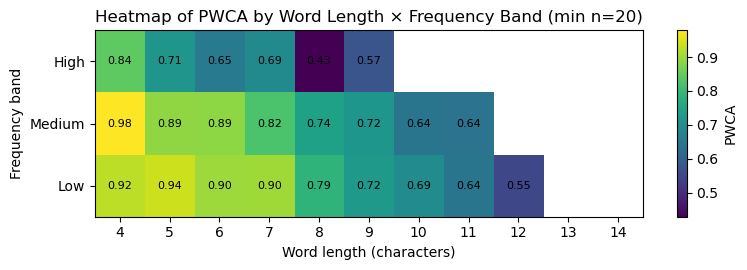

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RESULTS_CSV = "eval_results_with_band_and_length.csv"
METRIC = "pwca"                  # "pwca" or "cer" or "exact"
BANDS = ["high", "medium", "low"]  # or ["high","low"]
MIN_N = 20                       # mask cells with fewer than this many samples

df = pd.read_csv(RESULTS_CSV)
df["band"] = df["band"].astype(str).str.strip().str.lower()
df = df[df["band"].isin(BANDS)].copy()

# Ensure numeric
df["length"] = pd.to_numeric(df["length"], errors="coerce")
df[METRIC] = pd.to_numeric(df[METRIC], errors="coerce")
df = df.dropna(subset=["length", "band", METRIC])

# Aggregate mean metric and counts per (band, length)
mean_tbl = df.groupby(["band", "length"])[METRIC].mean().unstack("length")
cnt_tbl  = df.groupby(["band", "length"])[METRIC].size().unstack("length")

# Order rows/cols
mean_tbl = mean_tbl.reindex(BANDS)
mean_tbl = mean_tbl.sort_index(axis=1)   # lengths increasing
cnt_tbl  = cnt_tbl.reindex(BANDS).reindex(mean_tbl.columns, axis=1)

# Mask low-count cells
Z = mean_tbl.to_numpy(dtype=float)
N = cnt_tbl.to_numpy(dtype=float)
Z_masked = np.ma.masked_where((N < MIN_N) | np.isnan(Z), Z)

# Plot
plt.figure(figsize=(8, 2.8))
im = plt.imshow(Z_masked, aspect="auto")  # no explicit colors requested

plt.yticks(range(len(BANDS)), [b.capitalize() for b in BANDS])
plt.xticks(range(len(mean_tbl.columns)), [str(int(c)) for c in mean_tbl.columns])
plt.xlabel("Word length (characters)")
plt.ylabel("Frequency band")
plt.title(f"Heatmap of {METRIC.upper()} by Word Length × Frequency Band (min n={MIN_N})")

cbar = plt.colorbar(im)
cbar.set_label(METRIC.upper())

# Optional: annotate values (comment out if too busy in 2-column)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        if not Z_masked.mask[i, j]:
            plt.text(j, i, f"{Z[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

# Optional save (recommended for IEEE)
# plt.savefig("heatmap_pwca_length_band.pdf", bbox_inches="tight")
# plt.savefig("heatmap_pwca_length_band.png", dpi=300, bbox_inches="tight")


## The End 🎉
